# A cloud of languages

A cloud of languages based on a letter-substitution distances between words (edit-distance, aka Levenshtein distance). Supposedly similar languages should be close to each other.

Background:
* https://alternativetransport.wordpress.com/2015/05/05/34/
* https://alternativetransport.wordpress.com/2015/05/04/how-much-does-language-change-when-it-travels/
* https://elms.wpcomstaging.com/2008/03/04/lexical-distance-among-languages-of-europe/
* https://qph.fs.quoracdn.net/main-qimg-714918f9d0216b36f286e92238f1a188
* Inspired by: https://twitter.com/EuroMinLang

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.manifold as manifold
import sklearn.cluster as cluster
import umap
from IPython.core.display import display, HTML
from adjustText import adjust_text

In [2]:
def plausible(c1,c2):
    # Returns plausibility of change from letter c1 to letter c2
    # αβγδεικλμνοπρςστυχψ абвгдежзийклмнопрстухцчшъыьэяј
    cl = 0.2 # Low cost
    cm = 0.5 # Mid
    ch = 0.8 # High
    groups = {'aàáâãäåāăæăă':cl, 'eēėěèéêëёәәĕө':cl, 'oøòóôöӧө':cl, 'uùúûüūųүӱ':cl, 'iіìíıыӹyӱýј':cl,
              'lḷľłl':cl, 'zźżžӟ':cl, 'cçĉčӵ':cl, 'śŝşšș':cl, 'ĝğġ':cl, 'nñņњҥң':cl, 'kķҡ':cl,
              'dðď':cm, 'hħ': cm, 'wv':cm, 
              'aoeiyæaàáâãäåāăăæeēėěèéêëёĕәәөoøòóôöӧuùúûüūųүӱiіìíıыӹyӱýј':cm,
              'ўl':ch, 'bv':ch, 'gkcĝğġkķҡ':ch, 'cszcçĉčӵśŝşšșzźżžӟ':ch, 'pf':ch}
    # The order is important here: unique pairings should go first; more general - after
    for g,val in groups.items():
        if c1 in g and c2 in g:
            return val
    return 1

print(plausible('a','b'))
print(plausible('a','e'))
print(plausible('a','ä'))

1
0.5
0.2


In [3]:
# Edit-distance (dynamic programming)
def edit_distance(s1, s2, smart=True, max_distance=7):
    # Levenschtein distance (edit distance).
    # If smart=True, considers some changes more likely.
    # max_distance is an arbitrarily limit, relevant for Scottish Gaelic with its long words
    n1 = len(s1)
    n2 = len(s2)
    mem = [[0 for j in range(n2+1)] for i in range(n1+1)]
    # mem is Number of edits so far
    for i in range(n1+1):
        for j in range(n2+1):
            if   i==0: mem[i][j] = j
            elif j==0: mem[i][j] = i
            elif s1[i-1]==s2[j-1]: mem[i][j] = mem[i-1][j-1]
            else:
                if not smart:
                    cost = 1
                else:
                    cost = plausible(s1[i-1], s2[j-1])
                mem[i][j] = min([cost+mem[i-1][j-1], 1+mem[i-1][j], 1+mem[i][j-1]])
    if not max_distance: return mem[n1][n2]
    else: return min([max_distance, mem[n1][n2]])

edit_distance('hlavä12345dd', 'golova12345')

4.7

In [4]:
# Read the data
with open('parallel_vocabs.txt', 'r', encoding="utf8") as f:
    lines = f.readlines()

In [5]:
# All symbols used in this vocab
chars = set()
for s in lines:
    for c in s.lower():
        chars.add(c)
print(''.join(sorted(list(chars))))

	
 '(),-/4@_abcdefghijklmnopqrstuvwxyzàáâãäåæçèéêëìíðñòóôõöøùúûüýÿāăćĉčďđēĕėěĝğġħīıķļľłńņňŕŗśŝşšūųźżžǩǯșʹʼˮαβγδεικλμνοπρςστυχψабвгдежзийклмнопрстуфхцчшъыьэюяёіјњўҡңҥүһәӟӧөӱӵӹḑ’


In [6]:
# Put data in boxes

prefixes = ['Mouse face', 'Pig face', 'Rabbit face', 'Cow face', 'Pig face', 'Frog face', 
            'Chicken', 'Wolf face', 'Fox face', 'Dog face', 'Cat face', 'Bear face', 'Bird', 
            'Horse face', 'Honeybee', 'Butterfly', 'Deer', 'Snake', 'Fish', 'Duck', 'Goat',
           'Chipmunk', 'Monkey', 'Boar', 'Otter', 'Beaver', 'Snail', 'Spider', 'Ant',
           'Swan', 'Fly', 'Owl', 'Hedgehog', 'Sheep']
box = {s : s.split(' ')[0].lower() for s in prefixes}
box['Chicken'] = 'hen'
box['Baby chick'] = 'chicken'
box['Lady beetle'] = 'ladybug'

summary = {}    
bag = {}

lang = ''
head_flag = False
for s in lines:
    s = s.strip()  # Remove leading and trailing spaces
    if not s: continue # Skip empty lines
    if s[0]=='@':  # New language
        author = s
        head_flag = True # Expect new language
        continue
    if head_flag:
        if s[-5:]=='(big)': # For now isn't used, but may be useful for vizualization later
            big = True
            s = s[:-5].strip()
        else:
            big = False
        lang = s
        head_flag = False
        bag[lang] = bag.get(lang, {}) # In case the language is present more than once
        continue
    identified = False
    for key,value in box.items():        
        if s.find(key)==0:
            word = s[len(key):].lower()
            word = word.split(',')[0].split('/')[0].strip() # If more than one variant, pick the first one            
            bag[lang][value] = word
            summary[value] = summary.get(value, 0)+1
            identified = True
    if not identified:
        #print(s)
        pass
    
#print(bag)
print(summary)

{'dog': 111, 'cat': 111, 'mouse': 111, 'rabbit': 111, 'bear': 111, 'cow': 111, 'pig': 111, 'frog': 111, 'hen': 13, 'chicken': 12, 'bird': 111, 'wolf': 111, 'fox': 111, 'horse': 14, 'honeybee': 111, 'butterfly': 111, 'deer': 12, 'ladybug': 14, 'snake': 14, 'fish': 112, 'duck': 13, 'chipmunk': 12, 'goat': 13, 'monkey': 1, 'boar': 1, 'otter': 1, 'beaver': 1, 'snail': 1, 'ant': 3, 'spider': 3, 'fly': 2, 'sheep': 2, 'owl': 2, 'hedgehog': 2, 'swan': 1}


In [7]:
# Adjust alphabets

row1 = 'а б в г д е ж з и к л м н о п р с т у ф х ц ч ш ў α β γ δ ε ζ ι κ λ μ ν ο π ρ σ τ υ φ ξ χ ς ћ'.split(' ')
row2 = 'a b v g d e ž z i k l m n o p r s t u f h c č š ł a b g d e z i k l m n o p r s t u f x h s c'.split(' ')
translit = {row1[i] : row2[i] for i in range(len(row1))}

# We need deepcopy here, just copy won't be enough
newbag = {key:val.copy() for key,val in bag.items()}
for lang,words in newbag.items():
    for key,word in words.items():
        newbag[lang][key] = ''.join([translit[c] if c in translit else c for c in word ])

In [8]:
# Calculate distance matrix
# We use newbag everywhere, as it kills most of cyrillics

lang_list = list(newbag.keys())
nlangs = len(lang_list)
dist = np.zeros((nlangs,nlangs))

wordlist = ['dog', 'cat', 'mouse', 'rabbit', 'cow', 'pig', 'wolf', 'fox', 'bear', 'frog', 'bird', 
            'honeybee', 'butterfly', 'fish']
# Rabbit may be problematic because of the rabbit/hare split

for l1 in range(nlangs):
    print(lang_list[l1], end=' ')
    for l2 in range(l1):
        lang1 = lang_list[l1]
        lang2 = lang_list[l2]
        x = 0
        n = 0        
        for word in wordlist:
            if word in newbag[lang2].keys() and word in newbag[lang1].keys():
                x += edit_distance(newbag[lang1][word], newbag[lang2][word])
                n += 1
        dist[l1,l2] = x/n
        
# Post-processing
dist = dist + dist.T # Make symmetric
#dist

Sulrsilvan Lengadocian Aghul Sylt Frisian Lemosin Nissart Catalan Occitan Manx Sardinian Cornish Gallo Breton French Vallader Saintongeais Meadow Mari Gardenese Lothringian Sicilian Walloon Lombard Neapolitan Piedmontese Vivaro Genoese Welsh Irish Arpitan West Frisian Scots Corsican Asturian Aragonese Galician Alsatian Luxembourgish Basque Russian English Portuguese Castilian Icelandic Danish Swedish Finnish Estonian Latvian Lithuanian Belarusian Ukrainian Dutch German Italian Czech Slovak Polish Hungarian Slovenian Croatian Serbian Romanian Bulgarian Macedonian Albanian Greek Turkish Maltese Lower Sorbian Upper Sorbian Kashubian Tatar Bashkir Crimean Tatar Karaim Provencal Yiddish Ludza Livonian Övdalian Limburgish Lezgian Poitevin Hill Mari Udmurt Ludic Livvic Karela Faroese Nynorsk Chuvash Plattdeutsch Scottish Gaelic Izhorian Vepps Zyryan Perm Moksha Erzya Gutnish Rusyn Votic Plautdietsch Latgalian Voro Inari Saami North Saami Skolt Saami Nenets Romani Leivu 

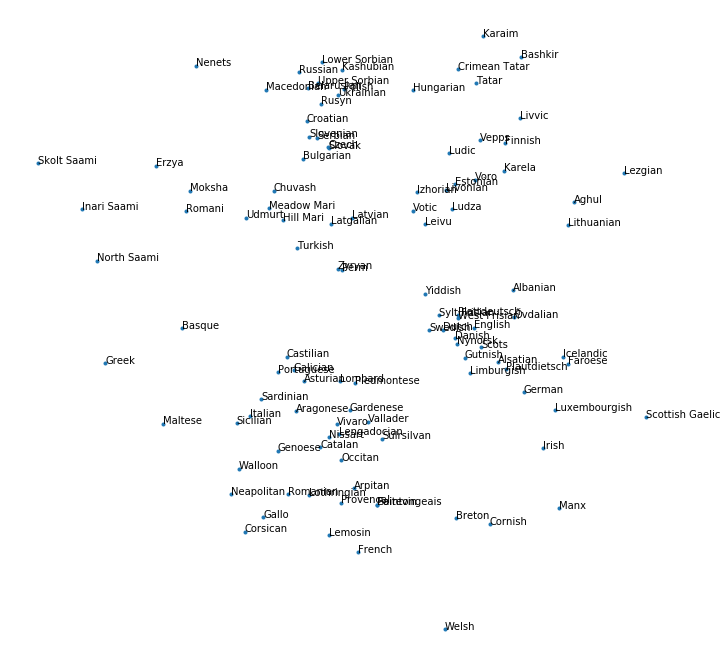

In [9]:
# MDS - doesn't really work, as it considers all distances, 
# and it's too much for this data.

emb = manifold.MDS(n_components=2, dissimilarity='precomputed', metric=True, n_init=10)
y = emb.fit_transform(np.square(dist))

plt.figure(figsize=(12,12), facecolor='white');
plt.axis('off');
plt.plot(y[:,0], y[:,1], '.');
for i in range(len(lang_list)):
    plt.text(y[i,0], y[i,1], lang_list[i])

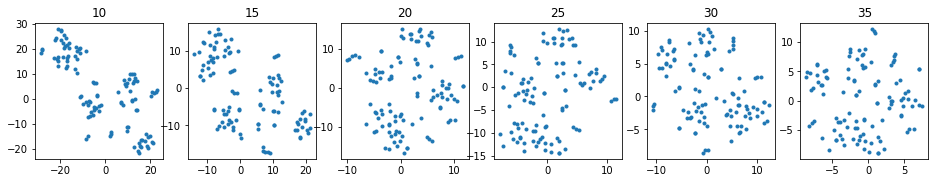

In [10]:
plt.figure(figsize=(16,2.5), facecolor='white');
pers = [10, 15, 20, 25, 30, 35]
for i in range(len(pers)):
    emb = manifold.TSNE(n_components=2, init='random', random_state=0, metric='precomputed',
                        perplexity=pers[i], n_iter=1000, learning_rate=100)
    y = emb.fit_transform(dist)
    plt.subplot(1,len(pers),i+1)
    plt.plot(y[:,0], y[:,1], '.');
    plt.title(pers[i])

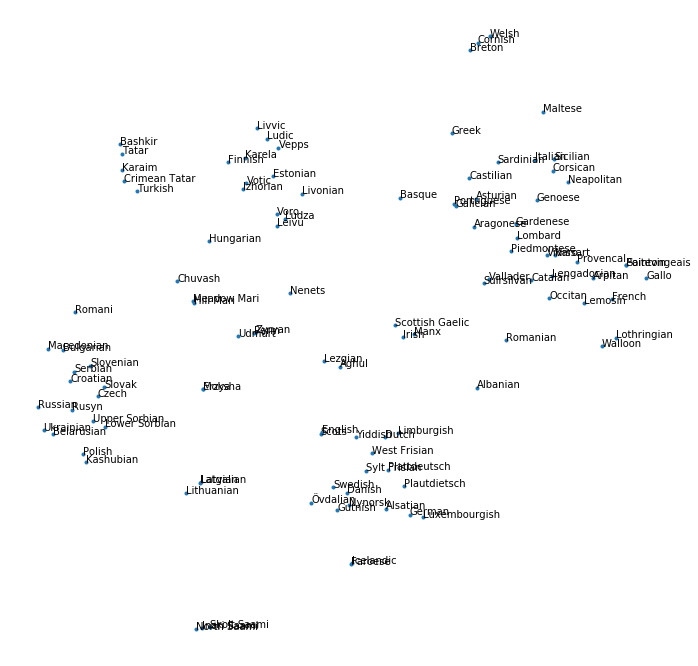

In [11]:
# tSNE Projection - slightly less horrible, but usually way too clamped,
# and with unstable, perfectly-overlapping points (like Baltic languages for some reason).

emb = manifold.TSNE(n_components=2, init='random', random_state=0, metric='precomputed',
                    perplexity=25, n_iter=10000, learning_rate=120)

# MDS - even more horrible
#emb = manifold.MDS(n_components=2, max_iter=1000, n_init=1, dissimilarity='precomputed')
# Spectral embedding - finicky, unpleasant
#emb = manifold.SpectralEmbedding(n_components=2, n_neighbors=30)

y = emb.fit_transform(np.square(dist)) # Seems to look better if squared

plt.figure(figsize=(12,12), facecolor='white');
plt.axis('off');
plt.plot(y[:,0], y[:,1], '.');
for i in range(len(lang_list)):
    plt.text(y[i,0], y[i,1], lang_list[i])

C:\Users\khakh\anaconda3\lib\site-packages\umap\umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


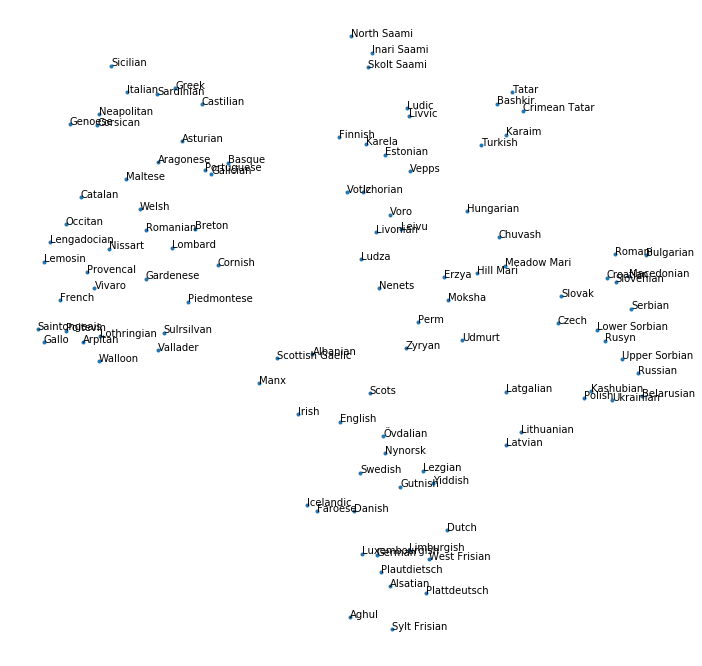

In [12]:
fit = umap.UMAP(metric='precomputed', n_neighbors=50, random_state=0)
y = fit.fit_transform(dist)

plt.figure(figsize=(12,12), facecolor='white');
plt.axis('off');
plt.plot(y[:,0], y[:,1], '.');
texts = []
for i in range(len(lang_list)):
    texts.append(plt.text(y[i,0], y[i,1], lang_list[i]))

# ggrepel-style: Quite slow, as it runs manual optimization of labels using spring forces
# Comment during troubleshooting, only add back once the pic itself is settled
# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='lightgray'))

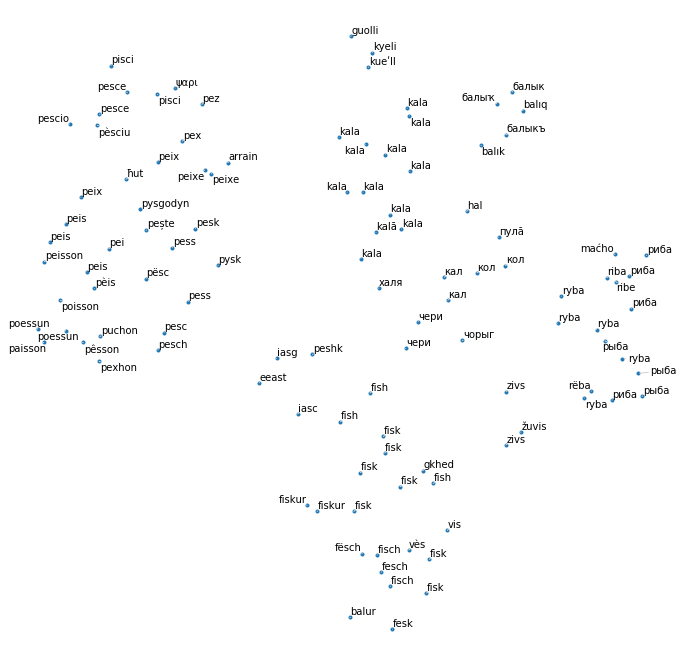

In [20]:
# Pick one word and plot it
plt.figure(figsize=(12,12), facecolor='white');
plt.axis('off');
plt.plot(y[:,0], y[:,1], '.');
texts = []
key = 'fish'
for i in range(len(lang_list)):
    if key in bag[lang_list[i]]:
        texts.append(plt.text(y[i,0], y[i,1], bag[lang_list[i]][key]))
    else:
        print(lang_list[i])
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='lightgray'));

And that's where the choice of parameters for embedding becomes political (or maybe "political" is too strong of a word, but it definitely starts to matter emotionally). If you set `n_neighbors` too low, every language only gets connected ot its friends, so you have a bunch of clusters hanging in the void. Which is fair, but boring (you really want Hungarian with its "medve" reach out to Slovak with its "mačka", or Chuvas being a link between Tatar and Mari). But if you make everything too connected, the entire cloud becomes too dense, which could put Irish close to Yddish, or to Lezgin, not because they are related, but siimply because everything is squished together a bit too much. And it may be awkward, as when people are seriously intersted in linguistincs (or, more generally, when people are seriously interested in anything), they become emotionally involved with little things like that. And while we know that the results of UMAP mean that similar languages would be placed close, _but not necessarily the other way around_, this is not at all obvious to a person looking at your cloud in a Twitter feed.

While the overall picture is interesting, don't overthink it. The problem this visualization faces is similar to that of world map projections: you kinda have to distort one part if you want to preserve the other, and vice versa. Similar to how those projections that show the continents pretty similar to their "real shape", also cut the oceans up like a peeled orange. And still distort the continents :)

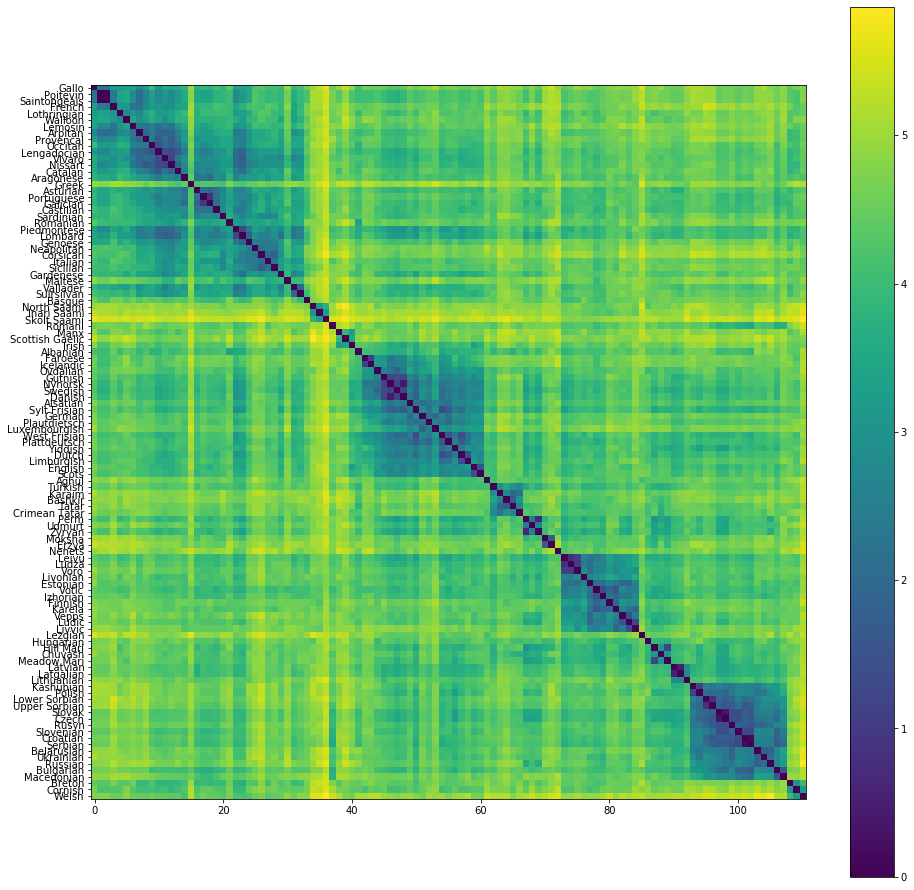

In [14]:
# Organize languages in a meaningful sequence

# emb = manifold.SpectralEmbedding(n_components=1, n_neighbors=50)

emb = manifold.TSNE(n_components=1, metric='precomputed', init='random', 
                    random_state=0, perplexity=30, learning_rate=30, n_iter=5000)
#emb = umap.UMAP(metric='precomputed', n_neighbors=20, random_state=0, n_components=1)
c = emb.fit_transform(dist).squeeze().tolist()
rank = np.argsort(c)

#c = cluster.AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=20).fit(dist)
#print(c.labels_)
#rank = np.argsort(c.labels_)

# Test the distances
n = dist.shape[0]
d = dist[rank,:]
d = d[:,rank]
plt.figure(figsize=(16,16), facecolor='white')
plt.imshow(d);
plt.colorbar();
plt.yticks(ticks=range(n), labels=[lang_list[i] for i in rank]);

In [15]:
print([lang_list[i] for i in rank])

['Gallo', 'Poitevin', 'Saintongeais', 'French', 'Lothringian', 'Walloon', 'Lemosin', 'Arpitan', 'Provencal', 'Occitan', 'Lengadocian', 'Vivaro', 'Nissart', 'Catalan', 'Aragonese', 'Greek', 'Asturian', 'Portuguese', 'Galician', 'Castilian', 'Sardinian', 'Romanian', 'Piedmontese', 'Lombard', 'Genoese', 'Neapolitan', 'Corsican', 'Italian', 'Sicilian', 'Gardenese', 'Maltese', 'Vallader', 'Sulrsilvan', 'Basque', 'North Saami', 'Inari Saami', 'Skolt Saami', 'Romani', 'Manx', 'Scottish Gaelic', 'Irish', 'Albanian', 'Faroese', 'Icelandic', 'Övdalian', 'Gutnish', 'Nynorsk', 'Swedish', 'Danish', 'Alsatian', 'Sylt Frisian', 'German', 'Plautdietsch', 'Luxembourgish', 'West Frisian', 'Plattdeutsch', 'Yiddish', 'Dutch', 'Limburgish', 'English', 'Scots', 'Aghul', 'Turkish', 'Karaim', 'Bashkir', 'Tatar', 'Crimean Tatar', 'Perm', 'Udmurt', 'Zyryan', 'Moksha', 'Erzya', 'Nenets', 'Leivu', 'Ludza', 'Voro', 'Livonian', 'Estonian', 'Votic', 'Izhorian', 'Finnish', 'Karela', 'Vepps', 'Ludic', 'Livvic', 'Lezgi

In [16]:
# Output Table

# Create a data frame
df = pd.DataFrame()
for i in range(nlangs):
    name = lang_list[rank[i]]    
    for word in wordlist:
        if word in bag[name].keys():
            df.loc[name,word] = bag[name][word]
            
with open('vocab_table.html', 'w', encoding='UTF-8') as f:
    f.write('<!DOCTYPE html><html><head></head><body>')
    f.write(df.to_html())
    f.write('</body></html>')
            
#display(HTML(df.to_html()))

In [17]:
df.loc[['Erzya', 'Moksha']]

,dog,cat,mouse,rabbit,cow,pig,wolf,fox,bear,frog,bird,honeybee,butterfly,fish
Erzya,киска,катка,чеерь,кудонумуло,скал,туво,верьгиз,ривезь,овто,ватракш,нармунь,мекш,нимиляв,кал
Moksha,пине,ката,шеер,куднумол,тракс,тува,върьгаз,келазь,офта,ватракш,нармонь,меш,мелав,кал


In [18]:
df.loc[['Övdalian', 'Swedish', 'Nynorsk', 'Icelandic']]

,dog,cat,mouse,rabbit,cow,pig,wolf,fox,bear,frog,bird,honeybee,butterfly,fish
Övdalian,rakke,masse,maus,kanin,tjyr,grais,warg,röv,byönn,tuosk,fugel,bi,fyörolder,fisk
Swedish,hund,katt,mus,kanin,ko,gris,varg,räv,björn,groda,fågel,bi,fjäril,fisk
Nynorsk,hund,katt,mus,kanin,ku,gris,ulv,rev,bjørn,frosk,fugl,bie,sommarfugl,fisk
Icelandic,hundur,köttur,mús,kanína,kýr,svín,úlfur,refur,björn,froskur,fugl,býfluga,fiðrildi,fiskur


In [19]:
def distance(names):
    # Return a submatrix of distances
    ind = []
    for name in names:
        if name in lang_list:
            ind.append(lang_list.index(name))
    subnames = [lang_list[i] for i in ind]
    temp = dist[ind]    
    return pd.DataFrame(temp[:,ind], index=subnames, columns=subnames)
        
distance(['Erzya', 'Moksha', 'Shoksha', 'Dutch','Plattdeutsch', 'Belarusian', 'Ukrainian'])

,Erzya,Moksha,Dutch,Plattdeutsch,Belarusian,Ukrainian
Erzya,0.000000,1.735714,4.557143,4.664286,4.964286,4.900000
Moksha,1.735714,0.000000,4.271429,4.414286,4.828571,4.685714
Dutch,4.557143,4.271429,0.000000,1.700000,4.164286,4.057143
Plattdeutsch,4.664286,4.414286,1.700000,0.000000,4.007143,4.042857
Belarusian,4.964286,4.828571,4.164286,4.007143,0.000000,1.721429
Ukrainian,4.900000,4.685714,4.057143,4.042857,1.721429,0.000000


Template

```
Dog face 
Cat face 
Mouse face 
Rabbit face 
Bear face 
Cow face 
Pig face 
Frog face 
Wolf face 
Fox face 
Bird 
Fish 
Butterfly 
Honeybee 
```